Code for San Francisco

# CTA Homelessness data

## Purpose

The purpose of this notebook is to load in the sample data. Each sheet from the Excel file was saved out to a CSV with the corresponding name.

- Author: Matt Mollison
- Date: 2016-10-12


In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# %load_ext autoreload
# # the "1" means: always reload modules marked with "%aimport"
# %autoreload 1

from __future__ import absolute_import, division, print_function
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os, sys
# from tqdm import tqdm
# import warnings

sns.set_context("poster", font_scale=1.0)

In [2]:
pd.set_option('display.max_columns', 100)

In [3]:
# Example for adding path
# write code in ../source and add that to runtime path
# src_dir = os.path.join(os.getcwd(), os.pardir, '../source')
# sys.path.append(src_dir)

# Import like so
# # import my_module from the source directory
# %aimport my_module
# from my_module.build_features import remove_invalid_data

In [4]:
# where the data is stored
datadir = os.path.join(os.getenv('HOME'), 'data/c4sf/DATA_CTA/SampleDataSet-MOSBE&SCz-2012-1001--2016-0531/USE THIS ONE/')

In [5]:
def encode_boolean(df, col):
    '''Encode values as booleans.
    If the string is 'Yes', the new value will be True. Otherwise it will be False.
    '''
    df.loc[df[col] == 'Yes', col] = True
    df.loc[df[col] == 'No', col] = False
    df.loc[df[col] == 'Not Applicable - Child', col] = False
    df.loc[df[col].isin(['Client refused',
                         "Client doesn't know",
                         'Data not collected',
                         '',
                         np.nan]), col] = False
    return df

In [6]:
def encode_unknown(df, col):
    '''Change non-informative values to 'Unknown'.
    '''
    df.loc[df[col].isin(['Client refused',
                         'Refused',
                         "Client doesn't know",
                         'Data not collected']), col] = 'Unknown'
    return df

In [7]:
sheet = 'Client'

cols = [
    'Personal ID',
    'Race',
    'Ethnicity',
    'Gender',
    'Veteran Status',
    ]

infile = os.path.join(datadir, '{s}.csv'.format(s=sheet))

df_client = pd.read_csv(infile, header=0, index_col=0, usecols=cols)
df_client = df_client.dropna(how='all')
df_client.index = df_client.index.astype('int')

# drop people that we don't have demographic information for
df_client = df_client.dropna(how='any', subset=['Race', 'Ethnicity', 'Gender'])

# fill in missing values
df_client['Veteran Status'] = df_client['Veteran Status'].fillna(value='')

# Remove "(HUD) from strings
cols = ['Race', 'Ethnicity', 'Veteran Status']
for col in cols:
    df_client[col] = df_client[col].apply(lambda x: x.replace(' (HUD)', ''))

# put the nans back
df_client.loc[df_client['Veteran Status'] == '', 'Veteran Status'] = np.nan

# and encode booleans
df_client = encode_boolean(df_client, 'Veteran Status')

# Some are unknown
df_client = encode_unknown(df_client, 'Race')
df_client = encode_unknown(df_client, 'Ethnicity')
df_client = encode_unknown(df_client, 'Gender')

In [8]:
df_client.head()

,Race,Ethnicity,Gender,Veteran Status
Personal ID,,,,
173781,White,Hispanic/Latino,Female,False
173782,White,Hispanic/Latino,Male,False
173783,White,Hispanic/Latino,Female,False
173800,Black or African American,Non-Hispanic/Non-Latino,Female,False
173803,White,Hispanic/Latino,Female,False


In [9]:
sheet = 'Enrollment'

cols = [
    'Personal ID',
    'Project Entry ID',
    'Client Age at Entry',
    'Last Permanent Zip',
    'Entry Date',
    'Exit Date',
    'Project ID',
    'Housing Status @ Project Start',
    'Living situation before program entry?',
    'Client Location',
    'Household ID',
    'Relationship to HoH',
    'Disabling Condition',
    'Continuously Homeless One Year',
    'Times Homeless Past Three Years',
    'Months Homeless This Time',
    'Chronic Homeless',
    'In Permanent Housing',
    'Residential Move In Date',
    'Domestic Violence Victim',
    'DV When Occurred',
    'DV Currently Fleeing',
    ]

infile = os.path.join(datadir, '{s}.csv'.format(s=sheet))

df_enroll = pd.read_csv(infile, header=0, index_col=0, usecols=cols,
                        parse_dates=['Entry Date', 'Exit Date', 'Residential Move In Date'],
                        infer_datetime_format=True)

df_enroll = df_enroll.dropna(axis=0, how='all')
df_enroll.index = df_enroll.index.astype('int')

# drop anyone for whom we don't have age
df_enroll = df_enroll.dropna(subset=['Client Age at Entry'])

# turn these into integers
cols = ['Project Entry ID', 'Client Age at Entry', 'Project ID', 'Household ID']
for col in cols:
    df_enroll[col] = df_enroll[col].astype('int')

# Remove "(HUD) from strings
cols = ['Housing Status @ Project Start',
        'Living situation before program entry?',
        'Disabling Condition',
        'Continuously Homeless One Year',
        'Domestic Violence Victim',
        'DV When Occurred',
        'DV Currently Fleeing',
        ]
for col in cols:
    df_enroll[col] = df_enroll[col].fillna(value='')
    df_enroll[col] = df_enroll[col].apply(lambda x: x.replace(' (HUD)', ''))
    # put the nans back
    df_enroll.loc[df_enroll[col] == '', col] = np.nan

# encode booleans

# cols = [
#     'Disabling Condition',
#     'Continuously Homeless One Year',
#     'Chronic Homeless',
#     'In Permanent Housing',
#     'Domestic Violence Victim',
#     'DV Currently Fleeing', ]

col = 'Disabling Condition'
df_enroll = encode_boolean(df_enroll, col)

col = 'Continuously Homeless One Year'
df_enroll = encode_boolean(df_enroll, col)

col = 'Chronic Homeless'
df_enroll = encode_boolean(df_enroll, col)

col = 'In Permanent Housing'
df_enroll = encode_boolean(df_enroll, col)

col = 'Domestic Violence Victim'
df_enroll = encode_boolean(df_enroll, col)

col = 'DV Currently Fleeing'
df_enroll = encode_boolean(df_enroll, col)


In [10]:
# one person has a negative age. make it positive.
col = 'Client Age at Entry'
df_enroll.loc[df_enroll[col] < 0, col] = df_enroll.loc[df_enroll[col] < 0, col] * -1

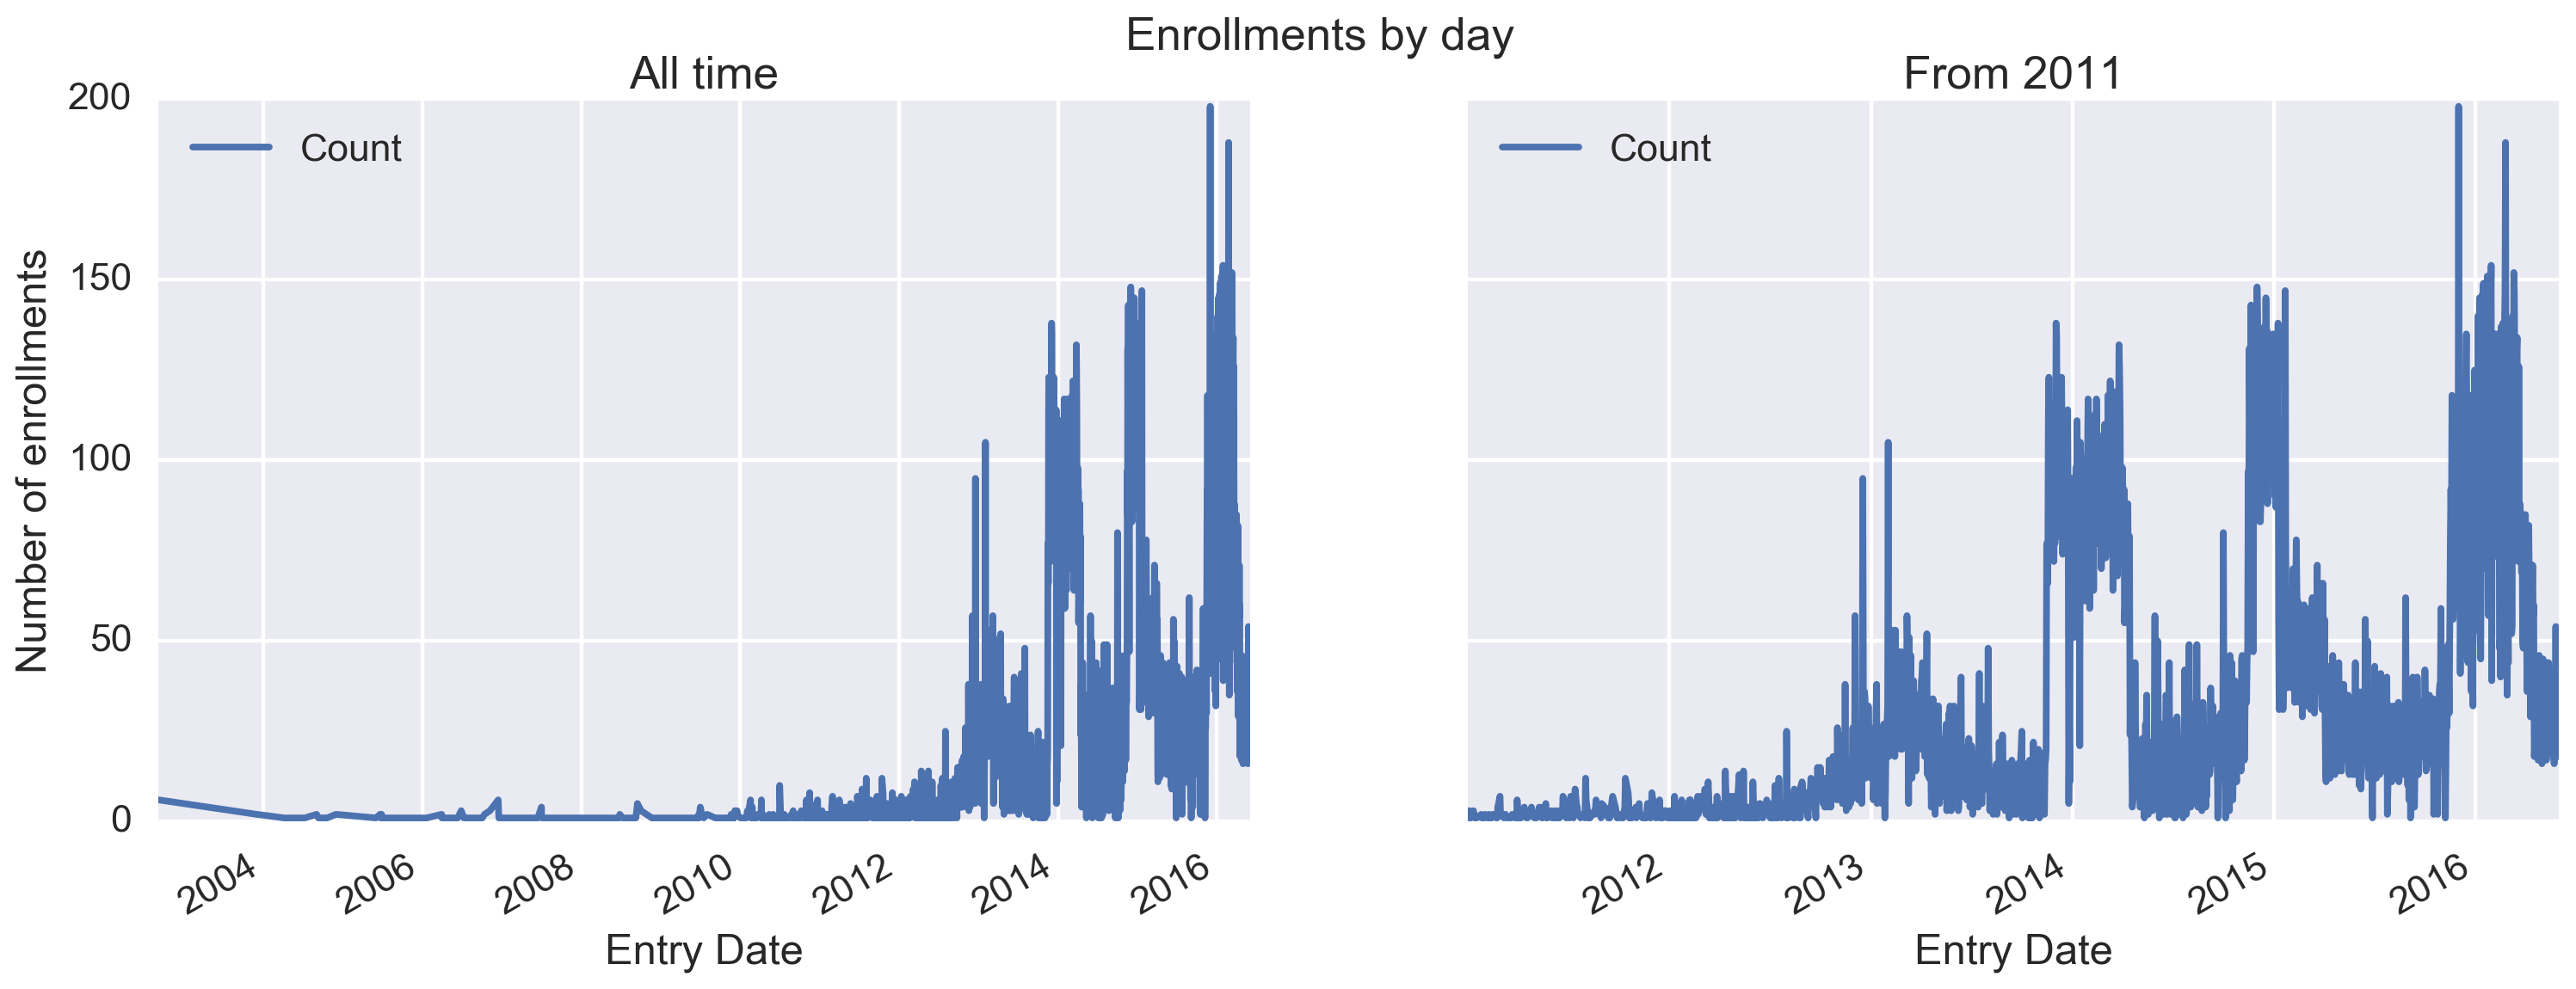

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), sharey=True)

# Not many entries in the system until 2011
df_enroll[['Entry Date']].reset_index().groupby(['Entry Date']).count().plot(ax=ax1);

# plot starting at 2011
df_enroll[['Entry Date']].reset_index().groupby(['Entry Date']).count().ix['2011':].plot(ax=ax2);

ax1.set(ylabel='Number of enrollments',
        title='All time',
        );

ax2.set(ylabel='Number of enrollments',
        title='From 2011',
        );

ax1.legend(['Count'], loc='best');
ax2.legend(['Count'], loc='best');

fig.suptitle('Enrollments by day');

In [12]:
sheet = 'Disability'

cols = [
    'Personal ID',
    'Disability Type',
    'Receiving Services For',
    'Disabilities ID',
    'Project Entry ID',
    ]

infile = os.path.join(datadir, '{s}.csv'.format(s=sheet))

df_disability = pd.read_csv(infile, header=0, index_col=0, usecols=cols)

df_disability = df_disability.dropna(axis=0, how='all')
df_disability.index = df_disability.index.astype('int')

# turn these into integers
cols = ['Disabilities ID', 'Project Entry ID']
for col in cols:
    df_disability[col] = df_disability[col].astype('int')

# Remove "(HUD) from strings
cols = ['Disability Type',
        'Receiving Services For',
        ]
for col in cols:
    df_disability[col] = df_disability[col].fillna(value='')
    df_disability[col] = df_disability[col].apply(lambda x: x.replace(' (HUD)', ''))
    # put the nans back
    df_disability.loc[df_disability[col] == '', col] = np.nan

# encode booleans
col = 'Receiving Services For'
df_disability = encode_boolean(df_disability, col)

In [13]:
df_disability.head()

,Disability Type,Receiving Services For,Disabilities ID,Project Entry ID
Personal ID,,,,
173848,Physical,True,971050,382788
173848,Physical,True,971050,383070
173848,Physical,True,971050,383336
173848,Physical,True,971050,383701
173848,Physical,True,971050,383839


In [14]:
df_disability['Disability Type'].value_counts()

Mental Health Problem          10238
Physical                        9474
Chronic Health Condition        5816
Both Alcohol and Drug Abuse     2586
Alcohol Abuse                   1777
Drug Abuse                      1749
Developmental                   1320
HIV/AIDS                         467
Substance Abuse                  133
Dual Diagnosis                    29
Other                             13
Vision Impaired                    5
Hearing Impaired                   2
Name: Disability Type, dtype: int64

In [15]:
sheet = 'HealthInsurance'

cols = [
    'Personal ID',
    'Health Insurance Information Date',
    'Health Insurance',
    'Data Collection Stage',
    ]

infile = os.path.join(datadir, '{s}.csv'.format(s=sheet))

df_healthins = pd.read_csv(infile, header=0, index_col=0, usecols=cols,
                           parse_dates=['Health Insurance Information Date'],
                           infer_datetime_format=True)

df_healthins = df_healthins.dropna(axis=0, how='all')
df_healthins.index = df_healthins.index.astype('int')


In [16]:
df_healthins.head()

,Health Insurance Information Date,Health Insurance,Data Collection Stage
Personal ID,,,
173781,2014-05-06,MEDICAID,Project Entry
173782,2014-05-06,MEDICARE,Project Entry
173783,2014-05-06,MEDICAID,Project Entry
173848,2014-08-22,MEDICAID,Project Entry
173848,2014-08-22,State Health Insurance for Adults,Project Entry


In [17]:
sheet = 'Benefit'

cols = [
    'Personal ID',
    'Non-Cash Benefit',
    'Data Collection Stage',
    ]

infile = os.path.join(datadir, '{s}.csv'.format(s=sheet))

df_benefit = pd.read_csv(infile, header=0, index_col=0, usecols=cols)

df_benefit = df_benefit.dropna(axis=0, how='all')
df_benefit.index = df_benefit.index.astype('int')

# Drop any project missing the code
df_benefit = df_benefit.dropna(how='any', subset=['Non-Cash Benefit'])

# Remove "(HUD) from strings
cols = ['Non-Cash Benefit',
        ]
for col in cols:
    df_benefit[col] = df_benefit[col].fillna(value='')
    df_benefit[col] = df_benefit[col].apply(lambda x: x.replace(' (HUD)', ''))
    # put the nans back
    df_benefit.loc[df_benefit[col] == '', col] = np.nan

# shorten some column values
col = 'Non-Cash Benefit'
df_benefit.loc[df_benefit[col] == 'Supplemental Nutrition Assistance Program (Food Stamps)', col] = 'Food Stamps'
df_benefit.loc[df_benefit[col] == 'Special Supplemental Nutrition Program for WIC', col] = 'WIC'
df_benefit.loc[df_benefit[col] == 'Section 8, Public Housing, or other ongoing rental assistance', col] = 'Section 8, Public Housing'

In [18]:
df_benefit.head()

,Non-Cash Benefit,Data Collection Stage
Personal ID,,
173781,Food Stamps,Project Entry
173781,Food Stamps,Project Entry
173803,Food Stamps,Project Entry
173848,Food Stamps,Project Entry
173848,Food Stamps,Project Entry


In [19]:
df_benefit['Non-Cash Benefit'].value_counts()

Food Stamps                     39412
Other Source                     2860
WIC                              2039
Section 8, Public Housing        1462
Other TANF-Funded Services        753
TANF Transportation Services      507
TANF Child Care Services          470
Temporary rental assistance       281
Name: Non-Cash Benefit, dtype: int64

In [20]:
df_benefit['Count'] = 1

In [21]:
# start making a pivot table of services that people get

# Count will probably correspond to the number of times someone has checked in

df_benefit.reset_index().groupby(by=['Personal ID', 'Non-Cash Benefit'], as_index=False).sum().pivot(
    index='Personal ID', columns='Non-Cash Benefit', values='Count').head()

Non-Cash Benefit,Food Stamps,Other Source,Other TANF-Funded Services,"Section 8, Public Housing",TANF Child Care Services,TANF Transportation Services,Temporary rental assistance,WIC
Personal ID,,,,,,,,
173781,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173803,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173848,782.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173885,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173899,114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
sheet = 'Income Entry & Exit'

cols = [
    'Personal ID',
    'Project Entry ID',
    'Entry Alimony',
    'Entry Child Support',
    'Entry Earned',
    'Entry GA',
    'Entry Other',
    'Entry Pension',
    'Entry Private Disability',
    'Entry Social Security Retirement',
    'Entry SSDI',
    'Entry SSI',
    'Entry TANF',
    'Entry Unemployment',
    'Entry VA Non-Service',
    'Entry VA Service Connected',
    "Entry Worker's Compensation",
    'Entry Total Income',
    'Exit Alimony',
    'Exit Child Support',
    'Exit Earned',
    'Exit GA',
    'Exit Other',
    'Exit Pension',
    'Exit Private Disability',
    'Exit Social Security Retirement',
    'Exit SSDI',
    'Exit SSI',
    'Exit TANF',
    'Exit Unemployment',
    'Exit VA Non-Service',
    'Exit VA Service Connected',
    "Exit Worker's Compensation",
    'Exit Total Income',
    'Income Change',
    ]

infile = os.path.join(datadir, '{s}.csv'.format(s=sheet))

df_income = pd.read_csv(infile, header=0, index_col=0, usecols=cols)

df_income = df_income.dropna(axis=0, how='all')
df_income.index = df_income.index.astype('int')

# turn these into integers
cols = ['Project Entry ID']
for col in cols:
    df_income[col] = df_income[col].astype('int')

# assume all nans are $0
df_income = df_income.fillna(value='0')

# turn the dollar strings into integers
for col in df_income.columns:
    if col != 'Project Entry ID':
        df_income[col] = df_income[col].str.replace(',', '')
        df_income[col] = df_income[col].str.replace(r'[^-+\d.]', '').astype(int)

In [23]:
df_income.head()

,Project Entry ID,Entry Alimony,Entry Child Support,Entry Earned,Entry GA,Entry Other,Entry Pension,Entry Private Disability,Entry Social Security Retirement,Entry SSDI,Entry SSI,Entry TANF,Entry Unemployment,Entry VA Non-Service,Entry VA Service Connected,Entry Worker's Compensation,Entry Total Income,Exit Alimony,Exit Child Support,Exit Earned,Exit GA,Exit Other,Exit Pension,Exit Private Disability,Exit Social Security Retirement,Exit SSDI,Exit SSI,Exit TANF,Exit Unemployment,Exit VA Non-Service,Exit VA Service Connected,Exit Worker's Compensation,Exit Total Income,Income Change
Personal ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
173781,252608,0,0,0,0,0,0,0,0,0,0,607,0,0,0,0,607,0,0,0,0,0,0,0,0,0,0,607,0,0,0,0,607,0
173781,314080,0,0,0,0,0,0,0,0,0,0,1143,0,0,0,0,1143,0,0,0,0,0,0,0,0,0,0,1143,0,0,0,0,1143,0
173782,122915,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
173782,314084,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
173783,122916,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
sheet = 'Service'

cols =  [
    'Personal ID',
    'Services ID',
    'Date Provided',
    'Date Ended',
    'Service Code',
    'Description',
    'Project ID',
    'Record Type',
    'Project Entry ID',
    ]

infile = os.path.join(datadir, '{s}.csv'.format(s=sheet))

df_service = pd.read_csv(infile, header=0, index_col=0, usecols=cols,
                         parse_dates=['Date Provided', 'Date Ended'],
                         infer_datetime_format=True)

df_service = df_service.dropna(axis=0, how='all')
df_service.index = df_service.index.astype('int')

# Drop anyone missing these IDs
df_service = df_service.dropna(how='any', subset=['Project ID', 'Project Entry ID'])

# turn these into integers
cols = ['Project ID', 'Project Entry ID']
for col in cols:
    df_service[col] = df_service[col].astype('int')


In [25]:
df_service.head()

,Services ID,Date Provided,Date Ended,Service Code,Description,Project ID,Record Type,Project Entry ID
Personal ID,,,,,,,,
175155,7312345,2013-04-01,2013-04-02,BH-1800,Emergency Shelter,2840,Bed Night,382789
180665,7312348,2013-04-01,2013-04-02,BH-1800,Emergency Shelter,2840,Bed Night,382791
184317,7312343,2013-04-01,2013-04-02,BH-1800,Emergency Shelter,2840,Bed Night,382790
184431,7312350,2013-04-01,2013-04-02,BH-1800,Emergency Shelter,2840,Bed Night,483580
184502,7312340,2013-04-01,2013-04-02,BH-1800,Emergency Shelter,2840,Bed Night,382785


In [26]:
df_service.shape

(58441, 8)

In [27]:
df_service['Date Provided'].isnull().sum()

21838

In [28]:
df_service['Date Ended'].isnull().sum()

22454

In [29]:
# drop any null dates
df_service = df_service.dropna(subset=['Date Provided', 'Date Ended'])

In [30]:
df_service.shape

(35987, 8)

In [31]:
# calculate the number of days service was given
df_service['Days'] = ((df_service['Date Ended'] - df_service['Date Provided']) / np.timedelta64(1, 'D')).astype(int)

In [32]:
df_service['Days'].value_counts().head(10)

1     26338
0      4802
2      1063
3       758
4       218
5       144
6       140
7        91
11       91
27       87
Name: Days, dtype: int64

In [33]:
df_service['Date Provided'].min()

Timestamp('2012-03-08 00:00:00')

In [34]:
df_service['Date Provided'].max()

Timestamp('2016-05-31 00:00:00')

In [35]:
df_service['Description'].value_counts()

Emergency Shelter    35987
Name: Description, dtype: int64

In [36]:
# not sure what this corresponds to
df_service['Services ID'].value_counts().head(10)

7926199    1
8765981    1
8214476    1
8948696    1
9315352    1
9323344    1
9302595    1
9323014    1
8500753    1
8004713    1
Name: Services ID, dtype: int64

In [37]:
sheet = 'Project'

cols = [
    'Project ID',
    'Project Name',
    'Project Type Code',
    'Address City',
    ]

infile = os.path.join(datadir, '{s}.csv'.format(s=sheet))

df_project = pd.read_csv(infile, header=0, index_col=1, usecols=cols)

df_project.head()

df_project = df_project.dropna(axis=0, how='all')
df_project.index = df_project.index.astype('int')

# Drop any project missing the code
df_project = df_project.dropna(how='any', subset=['Project Type Code'])

# Remove "(HUD) from strings
cols = ['Project Type Code',
        ]
for col in cols:
    df_project[col] = df_project[col].fillna(value='')
    df_project[col] = df_project[col].apply(lambda x: x.replace(' (HUD)', ''))
    # put the nans back
    df_project.loc[df_project[col] == '', col] = np.nan


In [38]:
df_project.head()

,Project Name,Project Type Code,Address City
Project ID,,,
2142,MOSBE CHS - Elm House,Transitional housing,NaN
2142,MOSBE CHS - Elm House,Transitional housing,NaN
3417,MOSBE CHS - RHY - BCP ES,Emergency Shelter,Monterey
3417,MOSBE CHS - RHY - BCP ES,Emergency Shelter,Seaside
3418,MOSBE CHS - RHY - BCP - HP,Homelessness Prevention,Monterey


In [39]:
sheet = 'BedInventory'

cols = [
    'Project ID',
    'Inventory ID',
    'Inventory Household Type',
    'HMIS Participating Beds',
    'Inventory Start Date',
    'Inventory End Date',
    'Unit Inventory',
    'Bed Inventory',
    'Vet Bed Inventory',
    'Youth Bed Inventory',
    'Youth Bed Age Group',
    ]

infile = os.path.join(datadir, '{s}.csv'.format(s=sheet))

df_bedinv = pd.read_csv(infile, header=0, index_col=0, usecols=cols,
                        parse_dates=['Inventory Start Date', 'Inventory End Date'],
                        infer_datetime_format=True)

df_bedinv = df_bedinv.dropna(axis=0, how='all')
df_bedinv.index = df_bedinv.index.astype('int')

# turn these into integers, assume zero if NaN
cols = ['Inventory ID', 'HMIS Participating Beds', 'Unit Inventory', 'Bed Inventory', 'Vet Bed Inventory', 'Youth Bed Inventory']
for col in cols:
    # df_bedinv[col] = df_bedinv.loc[~df_bedinv[col].isnull(), col].apply(lambda x: int(x))
    df_bedinv[col] = df_bedinv[col].fillna(value=0)
    df_bedinv[col] = df_bedinv[col].astype('int')


In [40]:
df_bedinv.head()

,Inventory ID,Inventory Household Type,HMIS Participating Beds,Inventory Start Date,Inventory End Date,Unit Inventory,Bed Inventory,Vet Bed Inventory,Youth Bed Inventory,Youth Bed Age Group
Project ID,,,,,,,,,,
2088,144,Households with at least one adult and one child,36,2001-01-01,2013-09-30,9,36,0,0,NaN
2088,655,Households with at least one adult and one child,36,2013-10-01,NaT,9,36,0,0,NaN
2095,194,Households without children,0,2004-01-01,2013-09-30,2,2,0,2,Only Ages 18-24
2095,678,Households without children,0,2013-10-01,NaT,4,4,0,4,Only Under Age 18
2101,145,Households with at least one adult and one child,24,1992-01-01,2013-09-30,5,24,0,0,NaN


# Clean data and make some features

In [41]:
# Only keep rows with entry dates starting in 2011
df_enroll = df_enroll[df_enroll['Entry Date'] >= '2011']

# Only keep rows with exit date
df_enroll = df_enroll[df_enroll['Exit Date'].notnull()]

In [42]:
df_client.head()

,Race,Ethnicity,Gender,Veteran Status
Personal ID,,,,
173781,White,Hispanic/Latino,Female,False
173782,White,Hispanic/Latino,Male,False
173783,White,Hispanic/Latino,Female,False
173800,Black or African American,Non-Hispanic/Non-Latino,Female,False
173803,White,Hispanic/Latino,Female,False


In [43]:
df_enroll.head()

,Project Entry ID,Client Age at Entry,Last Permanent Zip,Entry Date,Exit Date,Project ID,Housing Status @ Project Start,Living situation before program entry?,Client Location,Household ID,Relationship to HoH,Disabling Condition,Continuously Homeless One Year,Times Homeless Past Three Years,Months Homeless This Time,Chronic Homeless,In Permanent Housing,Residential Move In Date,Domestic Violence Victim,DV When Occurred,DV Currently Fleeing
Personal ID,,,,,,,,,,,,,,,,,,,,,
173781,252608,34,93907,2014-02-28,2014-02-28,2104,At-risk of homelessness,"Rental by client, no ongoing housing subsidy",NaN,252608,NaN,False,False,NaN,NaN,False,False,NaT,True,More than a year ago,False
173781,314080,35,93907,2014-05-06,2014-09-30,2101,Category 1 - Homeless,"Emergency shelter, including hotel or motel pa...",CA-506,314080,Head of household's child,False,False,2,NaN,False,False,NaT,True,From six to twelve months ago,False
173782,314084,10,93905,2014-05-06,2014-09-30,2101,Category 1 - Homeless,"Emergency shelter, including hotel or motel pa...",CA-506,314080,Head of household's child,False,True,2,NaN,False,False,NaT,True,From six to twelve months ago,False
173783,314085,12,93905,2014-05-06,2014-09-30,2101,Category 1 - Homeless,"Emergency shelter, including hotel or motel pa...",CA-506,314080,Head of household's child,False,True,2,NaN,False,False,NaT,True,From six to twelve months ago,False
173803,201286,32,93905,2013-02-08,2013-04-27,2101,Category 1 - Homeless,"Staying or living in a friend's room, apartmen...",NaN,201286,NaN,False,False,NaN,NaN,False,False,NaT,True,From six to twelve months ago,False


In [44]:
# calculate the number of days that someone was enrolled
df_enroll['Days Enrolled'] = ((df_enroll['Exit Date'] - df_enroll['Entry Date']) / np.timedelta64(1, 'D')).astype(int)

In [45]:
df_enroll['Days Enrolled'].value_counts().sort_index(ascending=True).head(10)

-5        1
 0      783
 1    35584
 2     1627
 3     1141
 4      496
 5      380
 6      324
 7      270
 8      200
Name: Days Enrolled, dtype: int64

In [46]:
# remove anyone with negative number of enrollment days
df_enroll = df_enroll[df_enroll['Days Enrolled'] >= 0]

In [47]:
df_enroll['Days Enrolled'].max()

1744

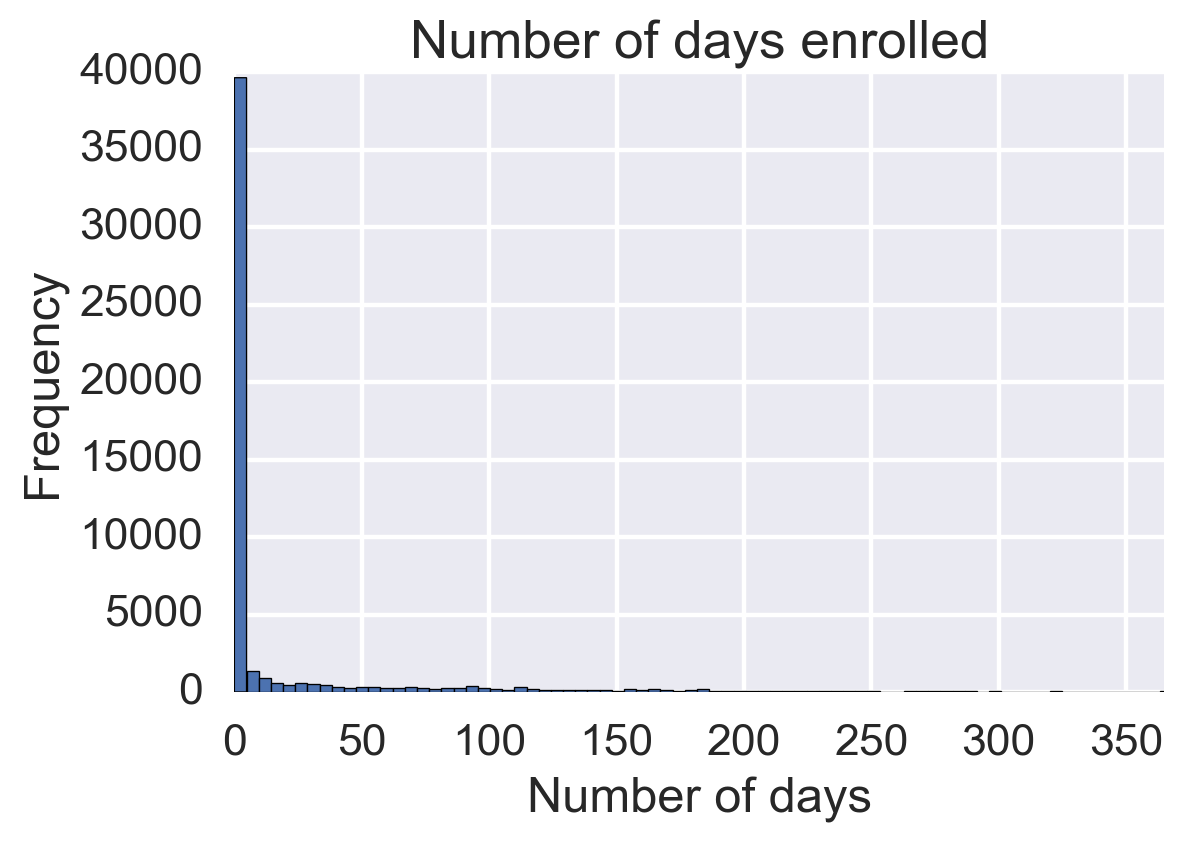

In [48]:
fig, ax = plt.subplots(figsize=(6, 4))

df_enroll['Days Enrolled'].plot(ax=ax, kind='hist', bins=365);

ax.set(title='Number of days enrolled',
       xlabel='Number of days',
       xlim=(0, 365));


In [49]:
# Join the client information with enrollment information.
# Inner join because we need both.
df = df_client.merge(df_enroll, how='inner', left_index=True, right_index=True)

In [50]:
df.head()

,Race,Ethnicity,Gender,Veteran Status,Project Entry ID,Client Age at Entry,Last Permanent Zip,Entry Date,Exit Date,Project ID,Housing Status @ Project Start,Living situation before program entry?,Client Location,Household ID,Relationship to HoH,Disabling Condition,Continuously Homeless One Year,Times Homeless Past Three Years,Months Homeless This Time,Chronic Homeless,In Permanent Housing,Residential Move In Date,Domestic Violence Victim,DV When Occurred,DV Currently Fleeing,Days Enrolled
Personal ID,,,,,,,,,,,,,,,,,,,,,,,,,,
173781,White,Hispanic/Latino,Female,False,252608,34,93907,2014-02-28,2014-02-28,2104,At-risk of homelessness,"Rental by client, no ongoing housing subsidy",NaN,252608,NaN,False,False,NaN,NaN,False,False,NaT,True,More than a year ago,False,0
173781,White,Hispanic/Latino,Female,False,314080,35,93907,2014-05-06,2014-09-30,2101,Category 1 - Homeless,"Emergency shelter, including hotel or motel pa...",CA-506,314080,Head of household's child,False,False,2,NaN,False,False,NaT,True,From six to twelve months ago,False,147
173782,White,Hispanic/Latino,Male,False,314084,10,93905,2014-05-06,2014-09-30,2101,Category 1 - Homeless,"Emergency shelter, including hotel or motel pa...",CA-506,314080,Head of household's child,False,True,2,NaN,False,False,NaT,True,From six to twelve months ago,False,147
173783,White,Hispanic/Latino,Female,False,314085,12,93905,2014-05-06,2014-09-30,2101,Category 1 - Homeless,"Emergency shelter, including hotel or motel pa...",CA-506,314080,Head of household's child,False,True,2,NaN,False,False,NaT,True,From six to twelve months ago,False,147
173803,White,Hispanic/Latino,Female,False,201286,32,93905,2013-02-08,2013-04-27,2101,Category 1 - Homeless,"Staying or living in a friend's room, apartmen...",NaN,201286,NaN,False,False,NaN,NaN,False,False,NaT,True,From six to twelve months ago,False,78


In [51]:
df = df.merge(df_benefit.reset_index().groupby(by=['Personal ID'])[['Non-Cash Benefit']].first(),
              how='left', left_index=True, right_index=True)

df['Non-Cash Benefit'] = df['Non-Cash Benefit'].fillna('None')

In [52]:
df = df.merge(df_disability.reset_index().groupby(by=['Personal ID'])[['Disability Type']].first(),
              how='left', left_index=True, right_index=True)

df['Disability Type'] = df['Disability Type'].fillna('None')

In [53]:
df.head()

,Race,Ethnicity,Gender,Veteran Status,Project Entry ID,Client Age at Entry,Last Permanent Zip,Entry Date,Exit Date,Project ID,Housing Status @ Project Start,Living situation before program entry?,Client Location,Household ID,Relationship to HoH,Disabling Condition,Continuously Homeless One Year,Times Homeless Past Three Years,Months Homeless This Time,Chronic Homeless,In Permanent Housing,Residential Move In Date,Domestic Violence Victim,DV When Occurred,DV Currently Fleeing,Days Enrolled,Non-Cash Benefit,Disability Type
Personal ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
173781,White,Hispanic/Latino,Female,False,252608,34,93907,2014-02-28,2014-02-28,2104,At-risk of homelessness,"Rental by client, no ongoing housing subsidy",NaN,252608,NaN,False,False,NaN,NaN,False,False,NaT,True,More than a year ago,False,0,Food Stamps,None
173781,White,Hispanic/Latino,Female,False,314080,35,93907,2014-05-06,2014-09-30,2101,Category 1 - Homeless,"Emergency shelter, including hotel or motel pa...",CA-506,314080,Head of household's child,False,False,2,NaN,False,False,NaT,True,From six to twelve months ago,False,147,Food Stamps,None
173782,White,Hispanic/Latino,Male,False,314084,10,93905,2014-05-06,2014-09-30,2101,Category 1 - Homeless,"Emergency shelter, including hotel or motel pa...",CA-506,314080,Head of household's child,False,True,2,NaN,False,False,NaT,True,From six to twelve months ago,False,147,None,None
173783,White,Hispanic/Latino,Female,False,314085,12,93905,2014-05-06,2014-09-30,2101,Category 1 - Homeless,"Emergency shelter, including hotel or motel pa...",CA-506,314080,Head of household's child,False,True,2,NaN,False,False,NaT,True,From six to twelve months ago,False,147,None,None
173803,White,Hispanic/Latino,Female,False,201286,32,93905,2013-02-08,2013-04-27,2101,Category 1 - Homeless,"Staying or living in a friend's room, apartmen...",NaN,201286,NaN,False,False,NaN,NaN,False,False,NaT,True,From six to twelve months ago,False,78,Food Stamps,None


In [54]:
# sort by entry date
df = df.sort_values('Entry Date')

In [56]:
# set up to count the number of times a person was in the system
df['Enrollments'] = 1

In [57]:
agg = {'Enrollments': 'sum',
       'Race': 'first',
       'Ethnicity': 'first',
       'Gender': 'first',
       'Veteran Status': 'max',
       'Client Age at Entry': 'last',
       'Days Enrolled': 'sum',
       'Chronic Homeless': 'max',
       'Continuously Homeless One Year': 'max',
       'Domestic Violence Victim': 'max',
       'Disability Type': 'last',
       'Non-Cash Benefit': 'last',
      }
df_sankey = df.reset_index().groupby(by=['Personal ID']).agg(agg)

In [58]:
df_sankey.shape

(11536, 12)

In [ ]:
# for col in df_sankey.columns:
#     print('\n')
#     print(df_sankey[col].value_counts().head(10))
#     print(df_sankey[col].value_counts().sum())
    

In [60]:
df_sankey.head()

,Gender,Enrollments,Chronic Homeless,Disability Type,Non-Cash Benefit,Client Age at Entry,Ethnicity,Continuously Homeless One Year,Domestic Violence Victim,Race,Veteran Status,Days Enrolled
Personal ID,,,,,,,,,,,,
173781,Female,2,False,None,Food Stamps,35,Hispanic/Latino,False,True,White,False,147
173782,Male,1,False,None,None,10,Hispanic/Latino,True,True,White,False,147
173783,Female,1,False,None,None,12,Hispanic/Latino,True,True,White,False,147
173803,Female,1,False,None,Food Stamps,32,Hispanic/Latino,False,True,White,False,78
173804,Female,1,False,None,None,11,Hispanic/Latino,False,False,White,False,78


In [61]:
df_sankey.shape

(11536, 12)

In [62]:
# turn into unique strings by prepending column name

# cols = ['Ethnicity',
#         'Race',
#         'Domestic Violence Victim',
#         'Gender',
#         'Continuously Homeless One Year',
#         'Veteran Status',
#         'Chronic Homeless',
#         ]
# for col in cols:

for col in df_sankey.columns:
    df_sankey[col] = df_sankey[col].apply(lambda x: '{}: {}'.format(col, x))

In [63]:
df_sankey.head()

,Gender,Enrollments,Chronic Homeless,Disability Type,Non-Cash Benefit,Client Age at Entry,Ethnicity,Continuously Homeless One Year,Domestic Violence Victim,Race,Veteran Status,Days Enrolled
Personal ID,,,,,,,,,,,,
173781,Gender: Female,Enrollments: 2,Chronic Homeless: False,Disability Type: None,Non-Cash Benefit: Food Stamps,Client Age at Entry: 35,Ethnicity: Hispanic/Latino,Continuously Homeless One Year: False,Domestic Violence Victim: True,Race: White,Veteran Status: False,Days Enrolled: 147
173782,Gender: Male,Enrollments: 1,Chronic Homeless: False,Disability Type: None,Non-Cash Benefit: None,Client Age at Entry: 10,Ethnicity: Hispanic/Latino,Continuously Homeless One Year: True,Domestic Violence Victim: True,Race: White,Veteran Status: False,Days Enrolled: 147
173783,Gender: Female,Enrollments: 1,Chronic Homeless: False,Disability Type: None,Non-Cash Benefit: None,Client Age at Entry: 12,Ethnicity: Hispanic/Latino,Continuously Homeless One Year: True,Domestic Violence Victim: True,Race: White,Veteran Status: False,Days Enrolled: 147
173803,Gender: Female,Enrollments: 1,Chronic Homeless: False,Disability Type: None,Non-Cash Benefit: Food Stamps,Client Age at Entry: 32,Ethnicity: Hispanic/Latino,Continuously Homeless One Year: False,Domestic Violence Victim: True,Race: White,Veteran Status: False,Days Enrolled: 78
173804,Gender: Female,Enrollments: 1,Chronic Homeless: False,Disability Type: None,Non-Cash Benefit: None,Client Age at Entry: 11,Ethnicity: Hispanic/Latino,Continuously Homeless One Year: False,Domestic Violence Victim: False,Race: White,Veteran Status: False,Days Enrolled: 78


In [67]:
df_sankey.to_csv(os.path.join(datadir, 'SFHomeless_2016-10-12_individ_features_strings.csv'))

# Ideas for plots

- Enrollments by zip code
- Enrollments by project

